<a href="https://colab.research.google.com/github/Sorin9202/SOLUX_summer_data/blob/master/4%EC%A3%BC%EC%B0%A8/bike_sharing_demand_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **시작 전 설치**

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"print030","key":"667022dc85abc597ad1b21ff0906e714"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c bike-sharing-demand

  0% 0.00/633k [00:00<?, ?B/s]
100% 633k/633k [00:00<00:00, 42.6MB/s]
  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 43.0MB/s]
  0% 0.00/316k [00:00<?, ?B/s]
100% 316k/316k [00:00<00:00, 105MB/s]


In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 13s (739 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

## **Load Dataset**

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프를 그리기 위해서
%matplotlib inline

#그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('train.csv', parse_dates = ["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv('test.csv', parse_dates=["datetime"])
test.shape

(6493, 9)

## **Feature Engineering**

In [5]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [6]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

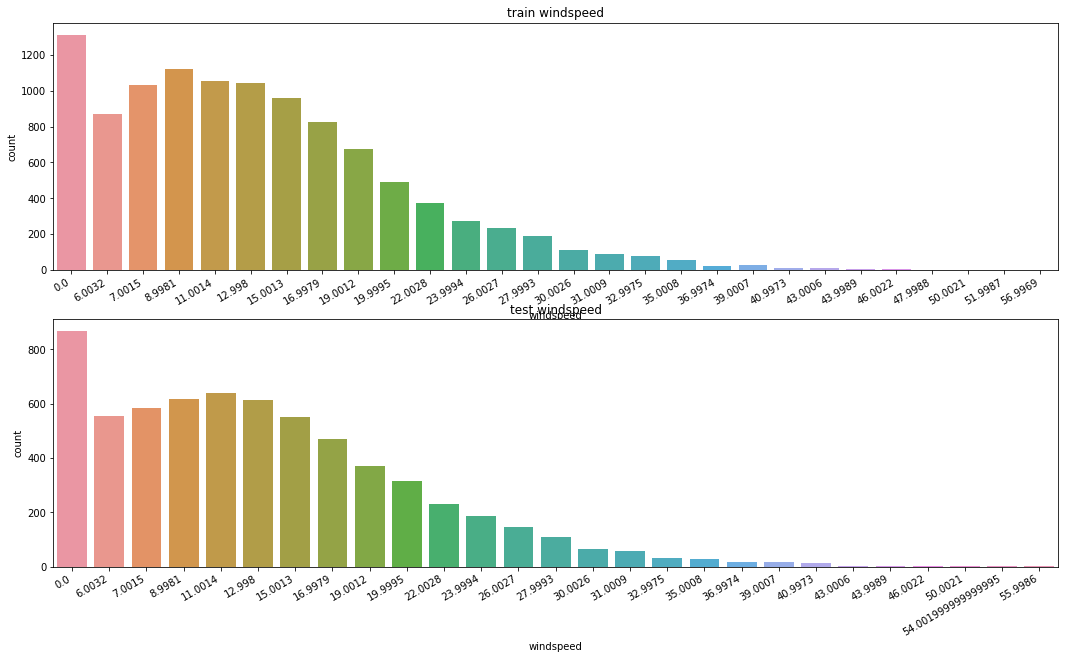

In [7]:
# windspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있다.
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30,  ha='right')
axes[0].set(ylabel='Count', title="train windspeed")
sns.countplot(data = train, x = "windspeed", ax = axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title="test windspeed")
sns.countplot(data = test, x = "windspeed", ax = axes[1])

In [ ]:
# 풍속의 0 값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될 것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [8]:
# 풍속이 0인 것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [9]:
# 그래서 머신 러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
  # 풍속이 0인 것과 아닌 것을 나누어준다.
  dataWind0 = data.loc[data['windspeed'] == 0]
  dataWindNot0 = data.loc[data['windspeed'] != 0]

  #풍속을 예측할 피쳐를 선택한다.
  wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

  # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
  dataWindNot0['windspeed'] = dataWindNot0["windspeed"].astype("str")

  # 랜덤포레스트 분류기를 사용한다.
  rfModel_wind = RandomForestClassifier()

  #wCol에 있는 피쳐의 값을 바탕으로 풍속을 학습시킨다.
  rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

  # 학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
  wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

  # 값을 다 예측 후 비교해 보기 위해
  # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
  predictWind0 = dataWind0
  predictWindNot0 = dataWindNot0

  # 값이 0으로 기록된 풍속에 대해 예측한 값을 넣어준다.
  predictWind0["windspeed"] = wind0Values

  # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
  data = predictWindNot0.append(predictWind0)

  # 풍속의 데이터 타입을 float으로 지정해 준다.
  data["windspeed"] = data["windspeed"].astype("float")

  data.reset_index(inplace=True)
  data.drop('index', inplace=True, axis=1)

  return data

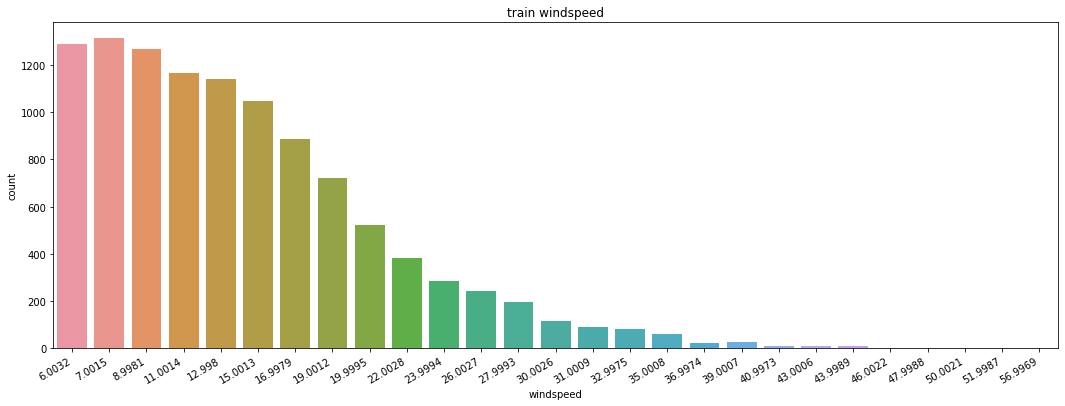

In [10]:
# 0값을 조정한다. train dataset만 고정
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0 값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

## **Feature Selection**

- 신호와 잡음은 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지는 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [11]:
# 연속형 feature 와 변주형 feature
# 연속형 feature = ["temp", "humidity", "windspeed", "atemp"]
# 범주형 feature의 type을 category로 변경해 준다.
categorical_feautre_name = ["season", "holiday", "workingday", "weather", "dayofweek",
                            "month", "year", "hour"]

for var in categorical_feautre_name:
  train[var] = train[var].astype("category")
  test[var] = test[var].astype("category")

In [15]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed", "year",
                 "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [16]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [17]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [18]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

## **Score**

**RMSLE**

 과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

In [19]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
  # 넘파이로 배열 형태로 바꿔준다.
  predicted_values = np.array(predicted_values)
  actual_values = np.array(actual_values)

  # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
  log_predict = np.log(predicted_values + 1)
  log_actual = np.log(actual_values + 1)

  # 위에서 계산된 예측값에서 실제값을 빼주고 제곱을 해준다.
  difference = log_predict - log_actual
  # difference = (log_predict - log_actual) ** 2
  difference = np.square(difference)

  # 평균을 낸다.
  mean_difference = difference.mean()

  # 다시 루트를 씌운다.
  score = np.sqrt(mean_difference)

  return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

### **Cross Validation 교차 검증**

- 일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다.

- KFold 교차검증

 - 데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
 - 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련 세트로 사용하여 학습한다.
 - 나머지 훈련 세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
 - 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련 세트를 두 번째 폴드로 정확도를 측정한다.
 - 이 과정을 마지막 폴드까지 반복한다.
 - 이렇게 훈련 세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균값을 낸 게 정확도가 된다.

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## **RandomForest**

In [21]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators = 100, n_jobs =1, random_state =0) #n_estimator 값을 높일 수록 결과가 근접하게 나옴.
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [24]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 34.9 s, sys: 71.5 ms, total: 35 s
Wall time: 35 s
Score= 0.33088


## **Train**

In [25]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [26]:
# 예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.5 ,   4.93,   4.11,   3.58,   3.19,   6.38,  38.13, 105.77,
       235.31, 136.83])

[Text(0.5, 1.0, 'test')]

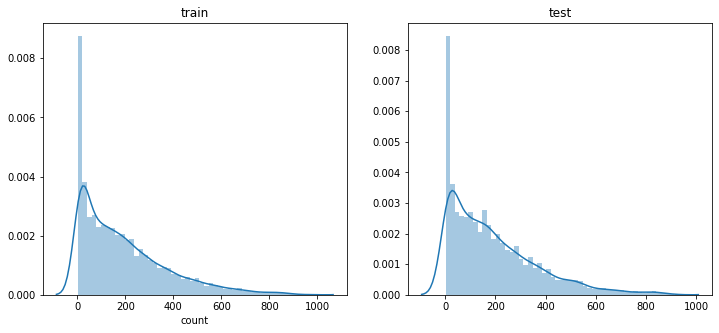

In [28]:
# 예측한 데이터를 시각화해본다.
# train dataset을 이용하여 학습시킴
fig, (ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")

## **Submit**

In [29]:
#submission 할 파일을 만든다.
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.50
1,2011-01-20 01:00:00,4.93
2,2011-01-20 02:00:00,4.11
3,2011-01-20 03:00:00,3.58
4,2011-01-20 04:00:00,3.19


In [30]:
submission.to_csv("Score_{0:.5f}_submission.csv".format(score), index=False)